In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [3]:
df = pd.read_csv("data.csv")

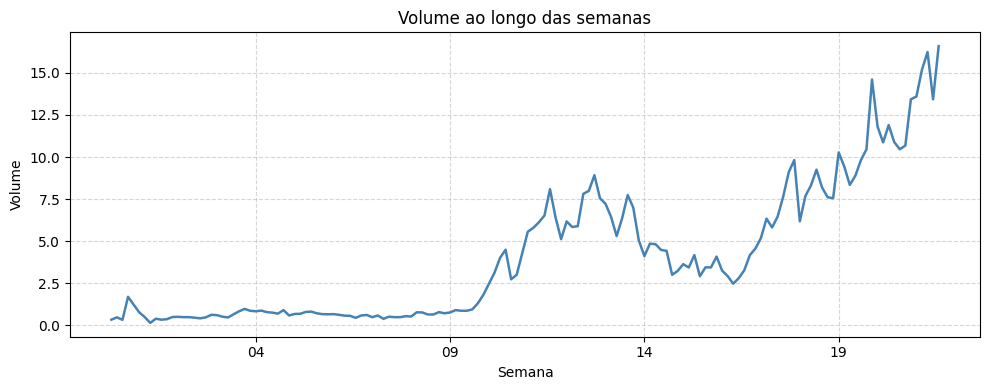

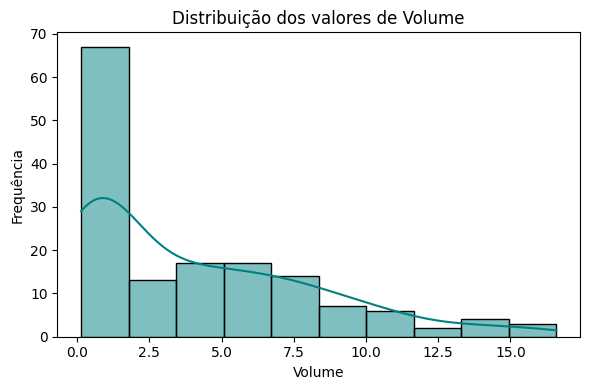

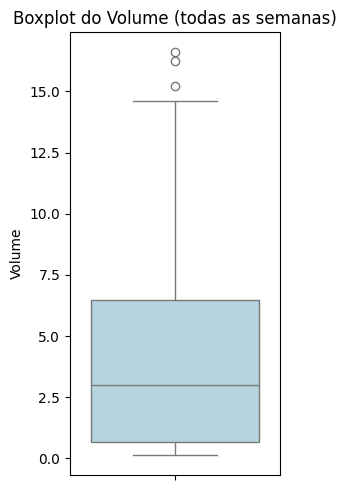

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['week'], df['volume'], color='steelblue', linewidth=1.8)
plt.title('Volume ao longo das semanas')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.grid(True, linestyle='--', alpha=0.5)
# mostra rótulos a cada 10 semanas
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%W'))
plt.tight_layout()
plt.show()

# Histograma
plt.figure(figsize=(6, 4))
sns.histplot(df['volume'], bins=10, kde=True, color='teal')
plt.title('Distribuição dos valores de Volume')
plt.xlabel('Volume')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(3, 5))
sns.boxplot(y=df['volume'], color='lightblue')
plt.title('Boxplot do Volume (todas as semanas)')
plt.ylabel('Volume')
plt.tight_layout()
plt.show()

O histograma e o boxplot indicam que a distribuição da variável volume é marcadamente assimétrica positiva. A maior parte das observações concentra-se em valores baixos, como evidenciado pela alta frequência de volumes entre 0 e 2.5 no histograma. O boxplot corrobora essa observação, mostrando que a mediana está mais próxima do primeiro quartil, e a presença de uma longa cauda superior com múltiplos outliers. Essa forte assimetria sugere que modelos lineares que pressupõem normalidade dos resíduos podem não performar bem com a variável na escala original, apontando para a necessidade de aplicar uma transformação para estabilizar a variância e aproximar a distribuição de uma simetria.

A análise da série temporal, que plota o volume em função da semana, revela que os dados não são estacionários. Há um comportamento distinto em dois regimes: nas primeiras 9 semanas, o volume se mantém em um patamar baixo e com pouca variabilidade. A partir da semana 9, inicia-se uma clara tendência de crescimento, acompanhada por um aumento na volatilidade. A existência dessa tendência é o fator mais crítico para a modelagem violando a independência das observações. Isso justifica a necessidade de decompor a série ou de criar co-variáveis baseadas no tempo para capturar esse efeito e modelá-lo adequadamente.

In [5]:
import io
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

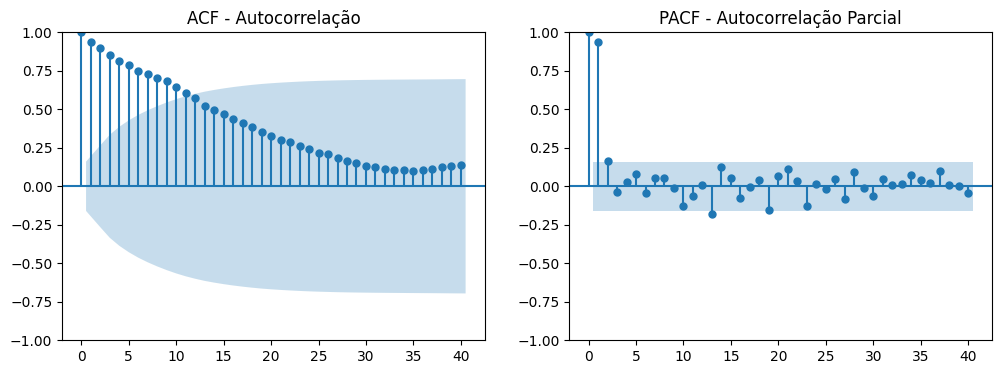

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = df.sort_values('week')
y = df['volume']

# Plot ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(y, lags=40, ax=axes[0])
plot_pacf(y, lags=40, ax=axes[1])
axes[0].set_title('ACF - Autocorrelação')
axes[1].set_title('PACF - Autocorrelação Parcial')
plt.show()

Foram gerados os gráficos da Função de Autocorrelação (ACF) e da Função de Autocorrelação Parcial (PACF). Ferramentas usadas para identificar a presença de tendência, sazonalidade e a natureza dos processos estocásticos subjacentes.

Gráfico ACF (Autocorrelação):
O gráfico ACF à esquerda exibe um decaimento lento e quase linear. As autocorrelações são muito altas e positivas para um grande número de lags, permanecendo estatisticamente significativas (fora do intervalo de confiança azul) para todos os 40 lags exibidos. Este padrão é a assinatura clássica de uma série temporal não-estacionária, confirmando a forte tendência de crescimento observada no gráfico de linha. A intuição é que, devido à tendência, uma observação em um ponto t será muito similar à observação em t-1, t-2, etc., simplesmente porque ambas estão na mesma trajetória ascendente, gerando uma alta correlação que só diminui muito lentamente com o tempo.

Análise do Gráfico PACF (Autocorrelação Parcial):
O gráfico PACF, por outro lado, nos mostra a correlação entre a série e um de seus lags após remover o efeito dos lags intermediários. O resultado é diferente: observa-se um pico muito significativo e positivo no lag 1, seguido por um corte abrupto. Após o primeiro lag, os valores da PACF caem imediatamente para dentro do intervalo de confiança, tornando-se não-significativos. Este comportamento sugere que, uma vez que a influência do valor imediatamente anterior t-1 é considerada, os valores mais antigos não adicionam uma informação nova e significativa para prever o valor atual.

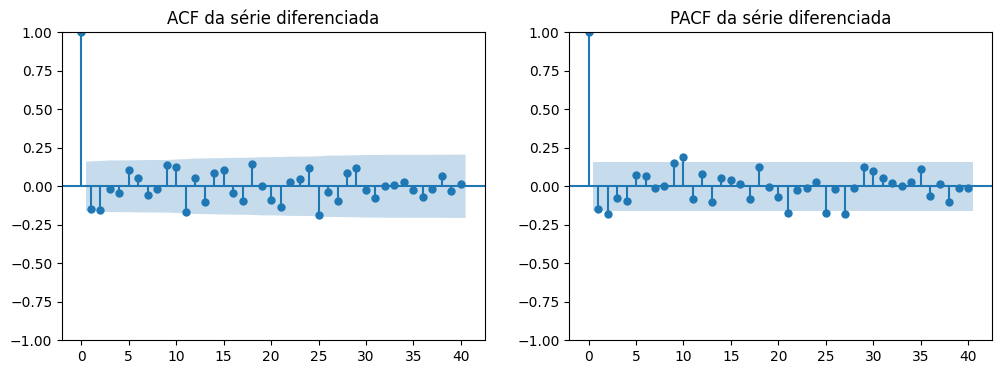

In [7]:
df['volume_diff'] = df['volume'].diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df['volume_diff'].dropna(), lags=40, ax=axes[0])
plot_pacf(df['volume_diff'].dropna(), lags=40, ax=axes[1])
axes[0].set_title('ACF da série diferenciada')
axes[1].set_title('PACF da série diferenciada')
plt.show()

Após aplicar uma primeira diferenciação para remover a tendência, os novos gráficos ACF e PACF tiveram uma transformação bem-sucedida, pois ambos os gráficos agora mostram que todas as autocorrelações estão dentro do intervalo de confiança (ou muito perto disso), indicando que a série se tornou estacionária.

O resultado se assemelha a um white noise, o que é uma forte evidência de que a série de volume original segue um processo de randon walk.

Isso estabelece o modelo ARIMA(0, 1, 0) como um excelente e robusto modelo baseline para o projeto. A partir dele, qualquer modelo mais complexo deve provar seu valor superando a simples previsão de que o próximo valor será igual ao último observado.

In [8]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


y = df['volume']

#Instanciar e treinar o modelo ARIMA(0, 1, 0)
model_arima = ARIMA(y, order=(0, 1, 0))
results_arima = model_arima.fit()
print(results_arima.summary())

# Previsão para os próximos 5 períodos
forecast = results_arima.get_forecast(steps=5)

# Extrair as previsões e os intervalos de confiança
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

print("\n--- Previsão para os próximos 5 períodos ---")
print("Último valor observado:", y.iloc[-1])
print("\nValores Previstos:")
print(predicted_mean)
print("\nIntervalos de Confiança (95%):")
print(confidence_intervals)

                               SARIMAX Results                                
Dep. Variable:                 volume   No. Observations:                  150
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -205.792
Date:                Mon, 06 Oct 2025   AIC                            413.584
Time:                        01:14:02   BIC                            416.588
Sample:                             0   HQIC                           414.804
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9272      0.061     15.217      0.000       0.808       1.047
Ljung-Box (L1) (Q):                   3.33   Jarque-Bera (JB):               113.56
Prob(Q):                              0.07   Pr

A análise do modelo baseline ARIMA(0, 1, 0) revela um resultado misto. Por um lado, o teste de Ljung-Box (Prob(Q) = 0.07) indica que o modelo foi bem-sucedido em remover a autocorrelação dos resíduos, significando que a diferenciação capturou a dependência temporal dos dados. Contudo, os testes de diagnóstico expõem falhas importantes: os resíduos não seguem uma distribuição normal (teste Jarque-Bera com Prob(JB) = 0.00), principalmente devido a uma alta curtose que sugere a presença de outliers. Além disso, o teste de heterocedasticidade (Prob(H) = 0.00) confirma que a variância dos erros não é constante.

A previsão gerada, que exibe uma tendência de queda em vez de se manter no último valor observado, mostra que o modelo ajustado foi, na verdade, uma "caminhada aleatória com drift negativo". Em conclusão, este modelo baseline cumpriu seu papel ao demonstrar que, embora a diferenciação trate a correlação, ela é insuficiente para lidar com a variância crescente e os valores extremos da série. Esses resultados validam a necessidade de avançar para uma abordagem mais robusta, como um modelo de regressão sobre a variável transformada (log(volume)), para tratar essas questões de forma mais eficaz.

In [9]:
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Divisão em Treino e Teste
train_size = int(len(df) * 0.8)
df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]
df_train['log_volume'] = np.log1p(df_train['volume'])
df_test['log_volume'] = np.log1p(df_test['volume'])

# Engenharia de Features
def create_features(data):
    data['week_num'] = data.index
    data['week_squared'] = data.index**2
    return data

df_train = create_features(df_train)
df_test = create_features(df_test)

# Treinamento do Modelo de Regressão Linear

features = ['week_num', 'week_squared']
X_train = df_train[features]
X_train = sm.add_constant(X_train) # Adiciona a constante (intercepto)
y_train = df_train['log_volume']

# Treinando o modelo OLS (Mínimos Quadrados Ordinários)
model_reg = sm.OLS(y_train, X_train)
results_reg = model_reg.fit()
print("--- Resumo do Modelo de Regressão ---")
print(results_reg.summary())


# Avaliando o Modelo de Regressão no conjunto de teste
X_test = df_test[features]
X_test = sm.add_constant(X_test)
predictions_log = results_reg.predict(X_test)

# Revertendo a transformação logarítmica para comparar na escala original
predictions_reg = np.expm1(predictions_log)

# Calculando as métricas de erro para o modelo de Regressão
rmse_reg = np.sqrt(mean_squared_error(df_test['volume'], predictions_reg))
mae_reg = mean_absolute_error(df_test['volume'], predictions_reg)

# Avaliando o Modelo Baseline (ARIMA) no mesmo conjunto de teste
model_arima = ARIMA(df_train['volume'], order=(0, 1, 0))
results_arima = model_arima.fit()
forecast_arima = results_arima.get_forecast(steps=len(df_test))
predictions_arima = forecast_arima.predicted_mean

# Calculando as métricas de erro para o modelo Baseline
rmse_arima = np.sqrt(mean_squared_error(df_test['volume'], predictions_arima))
mae_arima = mean_absolute_error(df_test['volume'], predictions_arima)

# C) Comparando os resultados
print("\n--- Comparação de Desempenho no Conjunto de Teste ---")
print(f"RMSE do Modelo Baseline (ARIMA): {rmse_arima:.4f}")
print(f"RMSE do Modelo de Regressão: {rmse_reg:.4f}")
print("-" * 20)
print(f"MAE do Modelo Baseline (ARIMA): {mae_arima:.4f}")
print(f"MAE do Modelo de Regressão: {mae_reg:.4f}")

--- Resumo do Modelo de Regressão ---
                            OLS Regression Results                            
Dep. Variable:             log_volume   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     116.0
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           1.70e-28
Time:                        01:46:48   Log-Likelihood:                -53.861
No. Observations:                 120   AIC:                             113.7
Df Residuals:                     117   BIC:                             122.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const     

A conclusão desta análise clara, a abordagem de regressão linear para modelar a tendência em log(volume) é superior ao modelo baseline de random walk. Isso é comprovado pela redução de quase 60% no erro de previsão (RMSE), que caiu de 4.68 para 1.90. O modelo final indica que o volume possui uma forte tendência de crescimento linear, e a transformação logarítmica foi essencial para estabilizar os dados.

Apesar do melhor desempenho preditivo, a análise dos resíduos do modelo de regressão deixa espaço pra melhoria. O teste Durbin-Watson (0.134) aponta que ainda existe autocorrelação nos erros, uma característica temporal que o modelo atual não capturou.

Este resultado estabelece um modelo robusto como ponto de partida. Para a próxima fase o foco será refinar este modelo, utilizando mais dados para corrigir a autocorrelação residual e aprimorar ainda mais a precisão das previsões.